In [1]:
import os
import ee
import datetime
import time
import sklearn
import io
import requests
import urllib.request

import geopandas as gp
import numpy as np
import pandas as pd
import rsfuncs as rs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.signal import savgol_filter
from dateutil.relativedelta import relativedelta
from sklearn import preprocessing
from shapely.ops import unary_union
from pandas.tseries.offsets import MonthEnd

ee.Initialize()

%load_ext autoreload
%autoreload 2

In [2]:
# Select area

shp = gp.read_file("../shape/argus_grace.shp")
sa_km3 = round(shp.area[0] * 10000, 2)
area = rs.gdf_to_ee_poly(shp)


In [3]:
# Set GRACE study period 

years = range(2003, 2018)
start = datetime.datetime(years[0], 1, 1)
end = datetime.datetime(years[-1]+1, 1, 1)
dt_idx = pd.date_range(start, end, freq = "MS")


In [4]:
# Load data
data = rs.load_data()

In [5]:
# Get grace products
cri = rs.get_grace(data['cri'], start, end, area)
mas = rs.get_grace(data['mas'], start, end, area)
gfz = rs.get_grace(data['gfz'], start, end, area)
csr = rs.get_grace(data['csr'], start, end, area)
jpl = rs.get_grace(data['jpl'], start, end, area)

processing:
ee.ImageCollection({
  "type": "Invocation",
  "arguments": {
    "id": "NASA/GRACE/MASS_GRIDS/MASCON_CRI"
  },
  "functionName": "ImageCollection.load"
})
progress:
0.0 % 
2.762 % 
5.524 % 
8.287 % 
11.04 % 
13.81 % 
16.57 % 
19.33 % 
22.09 % 
24.86 % 
27.62 % 
30.38 % 
33.14 % 
35.91 % 
38.67 % 
41.43 % 
44.19 % 
46.96 % 
49.72 % 
52.48 % 
55.24 % 
58.01 % 
60.77 % 
63.53 % 
66.29 % 
69.06 % 
71.82 % 
74.58 % 
77.34 % 
80.11 % 
82.87 % 
85.63 % 
88.39 % 
91.16 % 
93.92 % 
96.68 % 
99.44 % 
processing:
ee.ImageCollection({
  "type": "Invocation",
  "arguments": {
    "id": "NASA/GRACE/MASS_GRIDS/MASCON"
  },
  "functionName": "ImageCollection.load"
})
progress:
0.0 % 
2.762 % 
5.524 % 
8.287 % 
11.04 % 
13.81 % 
16.57 % 
19.33 % 
22.09 % 
24.86 % 
27.62 % 
30.38 % 
33.14 % 
35.91 % 
38.67 % 
41.43 % 
44.19 % 
46.96 % 
49.72 % 
52.48 % 
55.24 % 
58.01 % 
60.77 % 
63.53 % 
66.29 % 
69.06 % 
71.82 % 
74.58 % 
77.34 % 
80.11 % 
82.87 % 
85.63 % 
88.39 % 
91.16 % 
93.92 % 
96.6

In [6]:
# Now soil moisture, SWE, and reservoir storage. 
# Add an extra year beforehand, since we are differencing from the starting point, (e.g. dS/dt) 

In [7]:
# Soil moisture

# tc_sm = rs.calc_monthly_sum(data['tc_sm'], range(2002, 2018), range(1,13), area)
# gldas_sm = rs.calc_monthly_sum(data['gldas_sm'], range(2002, 2018), range(1,13), area)

tc_sm = rs.calc_monthly_mean(data['tc_sm'], datetime.datetime(years[0]-1, 1, 1), datetime.datetime(years[-1]+1, 1, 1), area)
gldas_sm = rs.calc_monthly_mean(data['gldas_sm'], datetime.datetime(years[0]-1, 1, 1), datetime.datetime(years[-1]+1, 1, 1), area)

# gldsm1 = rs.calc_monthly_sum(data['gsm1'], years, months, area)
# gldsm2 = rs.calc_monthly_sum(data['gsm2'], years, months, area)
# gldsm3 = rs.calc_monthly_sum(data['gsm3'], years, months, area)
# gldsm4 = rs.calc_monthly_sum(data['gsm4'], years, months, area)

processing:
ee.ImageCollection({
  "type": "Invocation",
  "arguments": {
    "id": "IDAHO_EPSCOR/TERRACLIMATE"
  },
  "functionName": "ImageCollection.load"
})
progress:
0.0 % 
2.590 % 
5.181 % 
7.772 % 
10.36 % 
12.95 % 
15.54 % 
18.13 % 
20.72 % 
23.31 % 
25.90 % 
28.49 % 
31.08 % 
33.67 % 
36.26 % 
38.86 % 
41.45 % 
44.04 % 
46.63 % 
49.22 % 
51.81 % 
54.40 % 
56.99 % 
59.58 % 
62.17 % 
64.76 % 
67.35 % 
69.94 % 
72.53 % 
75.12 % 
77.72 % 
80.31 % 
82.90 % 
85.49 % 
88.08 % 
90.67 % 
93.26 % 
95.85 % 
98.44 % 
processing:
ee.ImageCollection({
  "type": "Invocation",
  "arguments": {
    "id": "NASA/GLDAS/V021/NOAH/G025/T3H"
  },
  "functionName": "ImageCollection.load"
})
progress:
0.0 % 
2.590 % 
5.181 % 
7.772 % 
10.36 % 
12.95 % 
15.54 % 
18.13 % 
20.72 % 
23.31 % 
25.90 % 
28.49 % 
31.08 % 
33.67 % 
36.26 % 
38.86 % 
41.45 % 
44.04 % 
46.63 % 
49.22 % 
51.81 % 
54.40 % 
56.99 % 
59.58 % 
62.17 % 
64.76 % 
67.35 % 
69.94 % 
72.53 % 
75.12 % 
77.72 % 
80.31 % 
82.90 % 
85.49 % 
8

In [8]:
# SWE

# fldas_swe = rs.calc_monthly_sum(data['fldas_swe'], range(2002, 2018), range(1,13), area)
# gldas_swe = rs.calc_monthly_sum(data['gldas_swe'], range(2002, 2018), range(1,13), area)

fldas_swe = rs.calc_monthly_mean(data['fldas_swe'], datetime.datetime(years[0]-1, 1, 1), datetime.datetime(years[-1]+1, 1, 1), area)
gldas_swe = rs.calc_monthly_mean(data['gldas_swe'], datetime.datetime(years[0]-1, 1, 1), datetime.datetime(years[-1]+1, 1, 1), area)

# dmet_swe = rs.calc_monthly_sum(data['dmet_swe'], years, months, area)

processing:
ee.ImageCollection({
  "type": "Invocation",
  "arguments": {
    "id": "NASA/FLDAS/NOAH01/C/GL/M/V001"
  },
  "functionName": "ImageCollection.load"
})
progress:
0.0 % 
2.590 % 
5.181 % 
7.772 % 
10.36 % 
12.95 % 
15.54 % 
18.13 % 
20.72 % 
23.31 % 
25.90 % 
28.49 % 
31.08 % 
33.67 % 
36.26 % 
38.86 % 
41.45 % 
44.04 % 
46.63 % 
49.22 % 
51.81 % 
54.40 % 
56.99 % 
59.58 % 
62.17 % 
64.76 % 
67.35 % 
69.94 % 
72.53 % 
75.12 % 
77.72 % 
80.31 % 
82.90 % 
85.49 % 
88.08 % 
90.67 % 
93.26 % 
95.85 % 
98.44 % 
processing:
ee.ImageCollection({
  "type": "Invocation",
  "arguments": {
    "id": "NASA/GLDAS/V021/NOAH/G025/T3H"
  },
  "functionName": "ImageCollection.load"
})
progress:
0.0 % 
2.590 % 
5.181 % 
7.772 % 
10.36 % 
12.95 % 
15.54 % 
18.13 % 
20.72 % 
23.31 % 
25.90 % 
28.49 % 
31.08 % 
33.67 % 
36.26 % 
38.86 % 
41.45 % 
44.04 % 
46.63 % 
49.22 % 
51.81 % 
54.40 % 
56.99 % 
59.58 % 
62.17 % 
64.76 % 
67.35 % 
69.94 % 
72.53 % 
75.12 % 
77.72 % 
80.31 % 
82.90 % 
85.49 

In [9]:
# Reservoir Storage

reservoirs = gp.read_file("../shape/cdec_reservoirs.shp")
within_GRACE = gp.sjoin(reservoirs, shp, how='inner', op='within')

res_data = {}

for i in within_GRACE.ID:
    print("processing " + i )
    url = "https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations={}&SensorNums=15&dur_code=M&Start=2002-01-01&End=2017-12-31".format(i)
    urlData = requests.get(url).content
    df = pd.read_csv(io.StringIO(urlData.decode('utf-8')))
    
    if df.empty:
        pass
    else:
        res_data[i] = df


processing ABY
processing ADI
processing ADN
processing AGP
processing APH
processing ALT
processing AMF
processing APS
processing APU
processing ANT
processing ANR
processing ATS
processing ATP
processing AVL
processing ASH
processing ASM
processing ATW
processing ABR
processing AUB
processing BDF
processing BFK
processing BAL
processing BNG
processing BHM
processing BBS
processing CFW
processing BRM
processing BV1
processing BMD
processing BRD
processing BHV
processing BEM
processing BNH
processing BER
processing BGC
processing BFT
processing BGM
processing BMS
processing BP1
processing BP2
processing BP3
processing BWH
processing BGH
processing BIS
processing BSP
processing BSH
processing BLB
processing BLS
processing BCB
processing BMN
processing BLD
processing BLC
processing BYM
processing BLU
processing BLK
processing BCA
processing BOC
processing BDE
processing BNP
processing BNM
processing BOW
processing BOL
processing BOM
processing BWN
processing BXC
processing BWR
processing

In [10]:
# Unpack the reservoir storage data and make a timeseries sum for the whole study area 

res_s = []
res_df = {}

for k,v in res_data.items():
    result = pd.to_numeric(res_data[k].VALUE, errors = "coerce")
    if len(result) != 192:
        pass
    else:
        res_s.append(pd.to_numeric(res_data[k].VALUE, errors = "coerce"))
        res_df[k] = pd.to_numeric(res_data[k].VALUE, errors = "coerce")

res_ts = np.nansum(np.column_stack(res_s), axis = 1)


In [11]:
# for the other hydrology data, make a df starting 1 year earlier

years2 = range(2002, 2018)
months2 = range(1,13)
start2 = datetime.datetime(years2[0], 1, 1)
end2 = datetime.datetime(years2[-1]+1, 1, 1)
dt_idx2 = pd.date_range(start2,end2, freq='M')


df2 = pd.DataFrame([gldas_sm,tc_sm,gldas_swe,fldas_swe,res_ts*1.23348e-6]).T
df2.columns = ["gldas_sm", "tc_sm", "gldas_swe", "fldas_swe", "res_ts"]
df2.drop(df2.tail(1).index,inplace=True)
df2.index = dt_idx2 + MonthEnd(1)

In [12]:
df = pd.DataFrame([cri,gfz,jpl,mas,csr]).T
df.columns = ['cri','gfz','jpl','mas','csr']
df['grace_median'] = np.median( [df.cri,df.gfz,df.jpl,df.mas,df.csr] , axis = 0)
df.index = dt_idx
df.index = df.index + MonthEnd(1)

/anaconda3/envs/gis/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median for 46 results
  r = func(a, **kwargs)


In [13]:
## Now you have the Grace data in df and other dS data in df2 

# Merge them
fin_df = pd.merge(df, df2, how = "inner", left_index = True, right_index = True)

# Calculate mean SWE and SM 
fin_df['swe'] = np.mean([fin_df.gldas_swe, fin_df.fldas_swe], axis = 0)
fin_df['sm'] = np.mean([fin_df.tc_sm, fin_df.gldas_sm], axis = 0)

# Correct GRACE signal for sm, swe, reservoir storage 
fin_df['grace'] = fin_df.grace_median - fin_df.sm.diff()  - fin_df.swe.diff() - fin_df.res_ts.diff()

# Linear interpolation of missing values
fin_df['t'] = fin_df.grace.interpolate(method="linear")

# 2nd order polynomial interp
fin_df['adj'] = fin_df.grace.interpolate(method="polynomial", order = 2)

# apply SavGol filter 
# fin_df['ts_savgol'] = savgol_filter(fin_df.t, window_length=23, polyorder=2)

/anaconda3/envs/gis/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


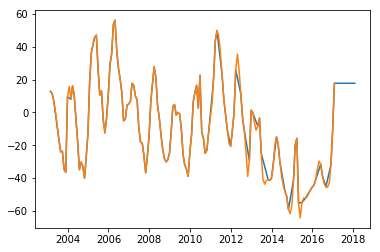

In [14]:
plt.plot(fin_df.t)
plt.plot(fin_df.adj)

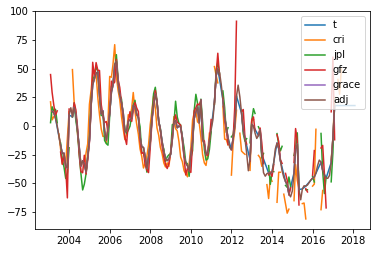

In [15]:
plt.plot(fin_df.t)
plt.plot(fin_df.cri)
plt.plot(fin_df.jpl)
plt.plot(fin_df.gfz)
plt.plot(fin_df.grace)
plt.plot(fin_df.adj)
# plt.plot(fin_df.ts_savgol)

plt.legend()

In [16]:
fin_df.to_csv("../data/GRACE_extended.csv")